<a href="https://colab.research.google.com/github/Bel-93/Curve-Demand-Exponencial-Negative/blob/main/Curve_Demanda_EX1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Curva de Demanda Exponencial Negativa**
### **Factor Precio**
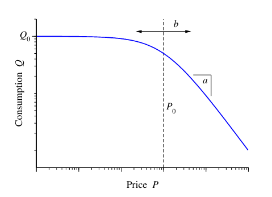

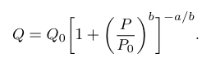

1.   **Importar Librerias**




In [ ]:
from __future__ import print_function,division #imprimir y división de datos
import sys
from sys import stderr,argv #Es un flujo de salida estándar para mensajes de error, y argv es una lista de argumentos pasados al script Python
from csv import reader
from numpy import array,linspace,mean,min,max,argmax,log,exp
from scipy.optimize import curve_fit # se utiliza para ajustar una función a datos mediante el método de mínimos cuadrados no lineales.
from pylab import figure,subplot,subplots_adjust,plot,savefig #Gráfico
from pylab import xscale,yscale,xlabel,ylabel,close #Gráfico

In [ ]:
# Formato imagen
# "eps", and "jpg"
image_format = "png"

# Reparar el input por si se trabaja con Python 2 o Python 3
try:
    input = raw_input
except NameError:
    pass

2.   **Definición de la función demanda exponencial negativa**

In [ ]:
# Log of demand curve
def logQ(P,Q0,P0,a,b):
    return log(Q0) - (a/b)*log(1+(P/P0)**b)

3.   **Data**

In [ ]:
# Obtener el nombre del archivo
if len(sys.argv) > 1:
    if sys.argv[1].startswith("-"):
        filebase = input("Enter the name of the CSV file: ")
    else:
        filebase = sys.argv[1]
else:
    filebase = input("Enter the name of the CSV file: ")

if ".csv" in filebase:
    endstr = filebase.find(".csv")
    filebase = filebase[:endstr]   # Remove ".csv"
if ".CSV" in filebase:
    endstr = filebase.find(".CSV")
    filebase = filebase[:endstr]   # Remove ".CSV"

filename = filebase + ".csv"
try:
    with open(filename, "r") as f:
        freader = reader(f)
        rawdata = [row for row in freader]
except FileNotFoundError:
    print("Unable to open file", filename, file=sys.stderr)
    sys.exit(1)

Enter the name of the CSV file: example


In [ ]:
#Vista del array
rawdata = rawdata[1:]

In [ ]:
rawdata #10 filas y primera columnna definida por precio y las demas columnas son las respuestas de reforzamiento de los animales a la droga

[['1.39', '5', '5', '6'],
 ['2.50', '10', '8', '8'],
 ['4.35', '12', '13', '16'],
 ['7.69', '19', '20', '22'],
 ['13.89', '28', '35', '39'],
 ['25.00', '31', '37', '40'],
 ['43.48', '37', '31', '19'],
 ['76.92', '22', '15', '10'],
 ['142.86', '8', '8', '4'],
 ['250.00', '4', '0', '2']]

In [ ]:
data = array(rawdata,float)
nprices = data.shape[0]       # Número observaciones precio
ncurves = data.shape[1] - 1   # Número de curvas o analisis por las columnas respuesta
print("Data read from file",filename)
print("  Price points:",nprices)
print("  Curves:      ",ncurves)
print()

Data read from file example.csv
  Price points: 10
  Curves:       3



In [ ]:
# Final entregable
outf = open(filebase+"_params.csv","w")
print('CURVE,Q0,P0,a,b,Rmax,Pmax,"Normalized Pmax"',file=outf)

4.   **Iteración y buscando los parámetros óptimos**

In [ ]:
for r in range(1,ncurves+1):

    print("Analizando curvas",r)

    # Pick out the non-zero data points
    Pdata = []
    Rdata = []
    for k in range(nprices):
        P = data[k,0]
        R = data[k,r]
        if R>0.0:
            Pdata.append(P)
            Rdata.append(R)
    Pdata = array(Pdata)
    Rdata = array(Rdata)
    Qdata = Rdata/Pdata

    # Rangos para los límites
    Plo = min(Pdata)
    Phi = max(Pdata)
    Qlo = min(Qdata)
    Qhi = max(Qdata)

    # Inicializando los parámetros
    if len(argv)>=6:
        Q0 = float(argv[2])
        P0 = float(argv[3])
        a = float(argv[4])
        b = float(argv[5])
    else:
        R0 = argmax(Rdata)
        P0 = Pdata[R0]
        Q0 = max(Qdata)
        a = 2.0
        b = 1.0

    param_init = [Q0,P0,a,b]
    param_max = 10000.0

    # Inicializando el entrenamiento
    try:
        popt,pcov = curve_fit(logQ,Pdata,log(Qdata),
                              p0=param_init,bounds=(0,param_max))
    except:
        print(r,',"DID NOT CONVERGE",,,,,',sep="",file=outf)
        print("  Caution: Fit did not converge")
        continue
    Q0,P0,a,b = popt
    Pmax = P0/(a-1)**(1/b)
    Qmax = exp(logQ(Pmax,Q0,P0,a,b))
    Rmax = Pmax*Qmax
    print(r,",",Q0,",",P0,",",a,",",b,",",Rmax,",",Pmax,",",Q0*Pmax,
          sep="",file=outf)

    # Fijar los rangos
    if Pmax<Plo or Pmax>Phi:
        print("  Caution: Pmax = ",float("%.2g"%Pmax)," is outside the data price range [",
              float("%.2g"%Plo)," to ",float("%.2g"%Phi),"]",sep="")
    if Q0>2*Qhi:
        print("  Caution: Q0 = ",float("%.2g"%Q0)," is substantially outside the data range [",
              float("%.2g"%Qlo)," to ",float("%.2g"%Qhi),"]",
              sep="")

    # Forma Gráfico
    figure(figsize=(10,6))
    subplots_adjust(left=0.1,right=0.95,top=0.95,bottom=0.1,wspace=0.3)

    # Plot curva de demanda
    subplot(1,2,1)
    Pfit = linspace(Plo,Phi,10001)
    Qfit = exp(logQ(Pfit,Q0,P0,a,b))
    plot(Pfit,Qfit,"g-")
    plot(Pdata,Qdata,"bo")
    xscale("log")
    yscale("log")
    xlabel("Price P")
    ylabel("Consumption Q")

    # Plot Revenue
    subplot(1,2,2)
    Rfit = Pfit*Qfit
    plot(Pfit,Rfit,"g-")
    plot(Pdata,Rdata,"bo")
    xlabel("Price P")
    ylabel("Responses R")
    xscale("log")

    # Save and close figure
    savefig(filebase+"_"+str(r)+"."+image_format)
    close()

outf.close()

Analizando curvas 1
  Caution: Pmax = 2300.0 is outside the data price range [1.4 to 250.0]
  Caution: Q0 = 25.0 is substantially outside the data range [0.016 to 4.0]
Analizando curvas 2
  Caution: Pmax = 0.28 is outside the data price range [1.4 to 140.0]
  Caution: Q0 = 10000.0 is substantially outside the data range [0.056 to 3.6]
Analizando curvas 3
  Caution: Pmax = 0.55 is outside the data price range [1.4 to 250.0]
  Caution: Q0 = 10000.0 is substantially outside the data range [0.008 to 4.3]


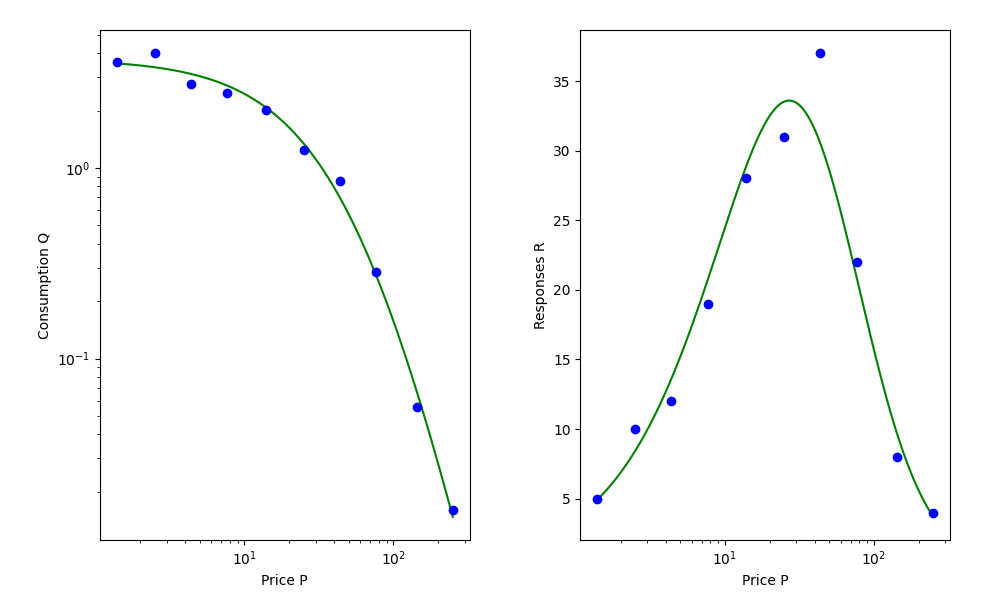